In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

50000/50000 [==============================] - 10s 206us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 11s 213us/step - loss: 2.4626 - acc: 0.0990 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 12s 248us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 12s 245us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4625 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dens

50000/50000 [==============================] - 10s 193us/step - loss: 2.7112 - acc: 0.6239 - val_loss: 2.9805 - val_acc: 0.5268
Epoch 49/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.6763 - acc: 0.6240 - val_loss: 2.9462 - val_acc: 0.5225
Epoch 50/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.6368 - acc: 0.6257 - val_loss: 2.9688 - val_acc: 0.5175
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)       

50000/50000 [==============================] - 9s 188us/step - loss: 0.8961 - acc: 0.6863 - val_loss: 1.5751 - val_acc: 0.4981
Epoch 50/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.8831 - acc: 0.6891 - val_loss: 1.3861 - val_acc: 0.5266
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 1

50000/50000 [==============================] - 9s 186us/step - loss: 0.8705 - acc: 0.6947 - val_loss: 1.3576 - val_acc: 0.5406


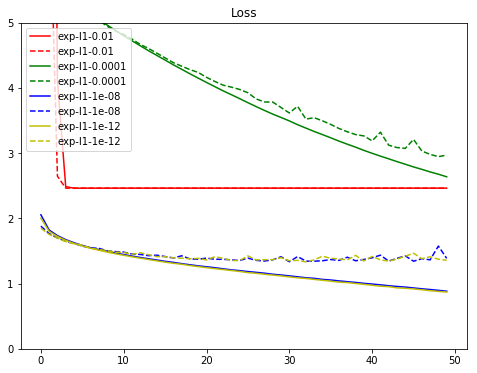

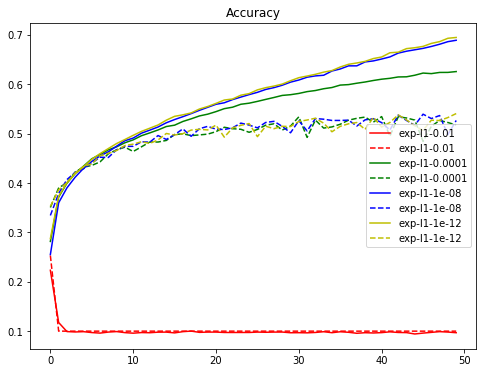

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [10]:
"""
建立神經網路，並加入 L1_l2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [12]:
results = {}
"""
使用迴圈建立不同的帶不同 L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 226us/step - loss: 18.8108 - acc: 0.2723 - val_loss: 17.3681 - val_acc: 0.3405
Epoch 2/50
50000/50000 [==============================] - 11s 220us/step - loss: 16.1414 - acc: 0.3599 - val_loss: 14.9732 - val_acc: 0.3776
Epoch 3/50
50000/50000 [==============================] - 11s 220us/step - loss: 13.9508 - acc: 0.3846 - val_loss: 12.9724 - val_acc: 0.3931
Epoch 4/50
50000/50000 [==============================] - 11s 222us/step - loss: 12.1004 - acc: 0.3981 - val_loss: 11.2623 - val_acc: 0.4062
Epoch 5/50
50000/50000 [==============================] - 11s 222us/step - loss: 10.5276 - acc: 0.4076 - val_loss: 9.8268 - val_acc: 0.4087
Epoch 6/50
50000/50000 [==============================] - 11s 212us/step - loss: 9.1901 - acc: 0.4165 - val_loss: 8.5978 - val_acc: 0.4075
Epoch 7/50
50000/50000 [==============================] - 11s 219us/step - loss: 8.0503 - acc: 0.4237 - val

50000/50000 [==============================] - 12s 233us/step - loss: 15.0653 - acc: 0.2769 - val_loss: 13.9376 - val_acc: 0.3438
Epoch 2/50
50000/50000 [==============================] - 11s 228us/step - loss: 13.0121 - acc: 0.3559 - val_loss: 12.1410 - val_acc: 0.3679
Epoch 3/50
50000/50000 [==============================] - 11s 218us/step - loss: 11.3413 - acc: 0.3807 - val_loss: 10.5918 - val_acc: 0.3829
Epoch 4/50
50000/50000 [==============================] - 11s 228us/step - loss: 9.9290 - acc: 0.3947 - val_loss: 9.2916 - val_acc: 0.3961
Epoch 5/50
50000/50000 [==============================] - 11s 218us/step - loss: 8.7289 - acc: 0.4046 - val_loss: 8.1849 - val_acc: 0.4088
Epoch 6/50
50000/50000 [==============================] - 11s 222us/step - loss: 7.7069 - acc: 0.4144 - val_loss: 7.2397 - val_acc: 0.4173
Epoch 7/50
50000/50000 [==============================] - 11s 221us/step - loss: 6.8351 - acc: 0.4226 - val_loss: 6.4495 - val_acc: 0.4216
Epoch 8/50
50000/50000 [========

Epoch 2/50
50000/50000 [==============================] - 11s 214us/step - loss: 12.9925 - acc: 0.3597 - val_loss: 12.1114 - val_acc: 0.3692
Epoch 3/50
50000/50000 [==============================] - 11s 219us/step - loss: 11.3220 - acc: 0.3849 - val_loss: 10.5755 - val_acc: 0.3932
Epoch 4/50
50000/50000 [==============================] - 11s 221us/step - loss: 9.9110 - acc: 0.3986 - val_loss: 9.2850 - val_acc: 0.3953
Epoch 5/50
50000/50000 [==============================] - 11s 221us/step - loss: 8.7114 - acc: 0.4087 - val_loss: 8.1698 - val_acc: 0.4123
Epoch 6/50
50000/50000 [==============================] - 11s 225us/step - loss: 7.6911 - acc: 0.4181 - val_loss: 7.2389 - val_acc: 0.4189
Epoch 7/50
50000/50000 [==============================] - 11s 215us/step - loss: 6.8233 - acc: 0.4215 - val_loss: 6.4299 - val_acc: 0.4293
Epoch 8/50
50000/50000 [==============================] - 11s 221us/step - loss: 6.0799 - acc: 0.4298 - val_loss: 5.7456 - val_acc: 0.4310
Epoch 9/50
50000/50000 

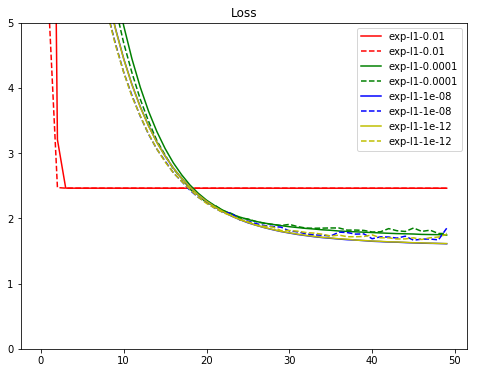

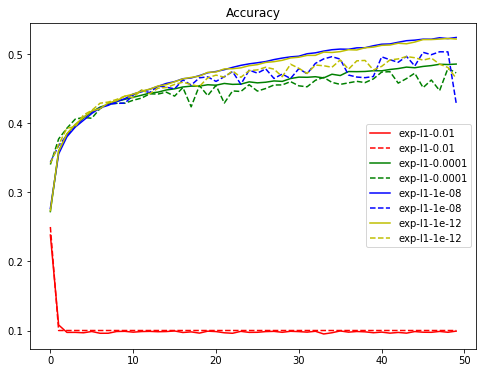

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()